In [ ]:
pip install tensorflow numpy matplotlib

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# --- 1. Persiapan Data (Fashion MNIST) ---
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Normalisasi data ke range [0, 1] dan tambah dimensi channel
x_train = np.expand_dims(x_train.astype("float32") / 255.0, -1)
x_test = np.expand_dims(x_test.astype("float32") / 255.0, -1)

input_shape = (28, 28, 1)
latent_dim = 2  # Dimensi latent space (2D agar mudah visualisasi)

# --- 2. Komponen VAE (Sampling Layer) ---
class Sampling(layers.Layer):
    """Menggunakan (z_mean, z_log_var) untuk sample z (vektor latent encoding)."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# --- 3. Membangun Encoder & Decoder ---
# Encoder
encoder_inputs = keras.Input(shape=input_shape)
x = layers.Flatten()(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(128, activation="relu")(latent_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(28 * 28, activation="sigmoid")(x)
decoder_outputs = layers.Reshape((28, 28, 1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# --- 4. Definisi Model VAE Lengkap ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            # Loss Rekonstruksi
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            # KL Divergence Loss
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss": self.total_loss_tracker.result(), "reconstruction_loss": self.reconstruction_loss_tracker.result(), "kl_loss": self.kl_loss_tracker.result()}

# --- 5. Membangun Autoencoder Biasa (Untuk Perbandingan) ---
ae_input = keras.Input(shape=input_shape)
ae_flat = layers.Flatten()(ae_input)
ae_encoded = layers.Dense(latent_dim, activation='relu')(ae_flat) # Botleneck ketat
ae_decoded_flat = layers.Dense(28*28, activation='sigmoid')(ae_encoded)
ae_output = layers.Reshape((28, 28, 1))(ae_decoded_flat)
autoencoder = keras.Model(ae_input, ae_output)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# --- Training ---
print("Training VAE...")
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128, verbose=1)

print("\nTraining Autoencoder Biasa...")
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, verbose=1)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training VAE...
Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - kl_loss: 7.1239 - loss: 341.5760 - reconstruction_loss: 334.4521
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - kl_loss: 6.0633 - loss: 274.7223 - reconstruction_loss: 268.6590
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - kl_loss: 6.0917 - loss: 269.9536 - reconstruction_loss: 263.8618
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - kl_loss: 6.0923 - loss: 267.3511 - reconstruction_loss: 261.2589
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - kl_loss: 6.1068 - loss: 265.0581 - reconstruction_loss: 258.9514
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - kl_loss: 6.1154 - loss: 264.3817 - reconstruction_loss: 258.2663
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - kl_loss: 6.1596 - 

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


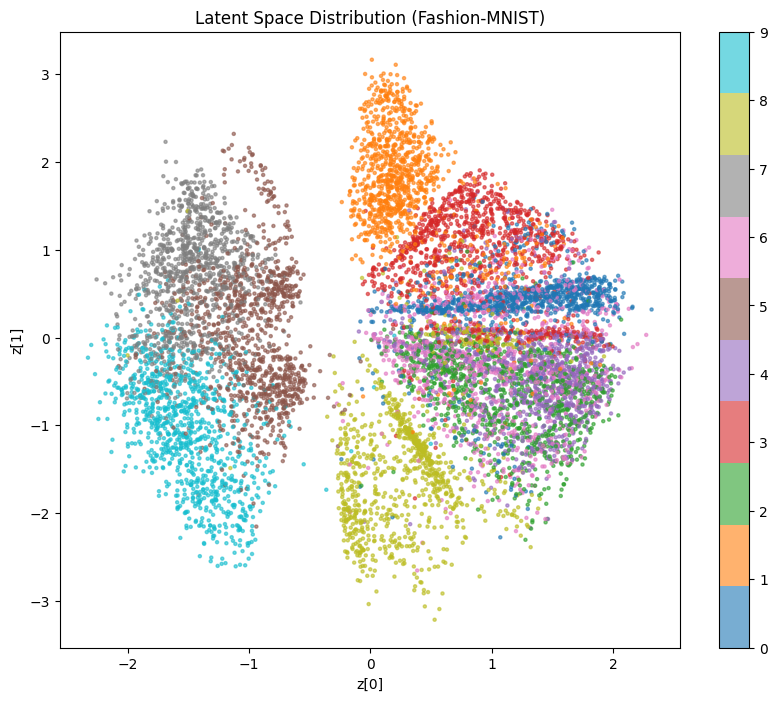

In [ ]:
def plot_latent_space(encoder, x_test, y_test):
    z_mean, _, _ = encoder.predict(x_test)
    plt.figure(figsize=(10, 8))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test, cmap='tab10', alpha=0.6, s=5)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title("Latent Space Distribution (Fashion-MNIST)")
    plt.show()

plot_latent_space(encoder, x_test, y_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


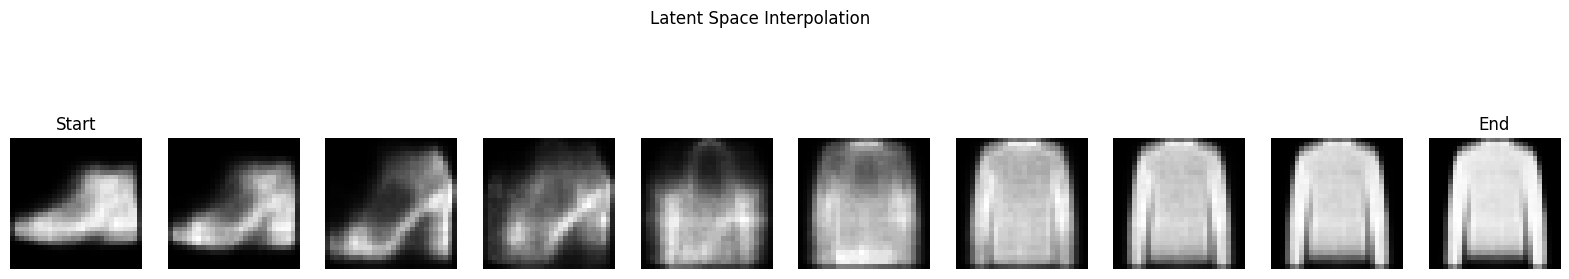

In [ ]:
def plot_interpolation(model, start_img, end_img, steps=10):
    # Encode kedua gambar untuk mendapatkan koordinat latent-nya
    start_z, _, _ = model.encoder.predict(np.expand_dims(start_img, 0))
    end_z, _, _ = model.encoder.predict(np.expand_dims(end_img, 0))

    # Linear Interpolation (Lerp) antara dua vektor latent
    vectors = []
    alpha_values = np.linspace(0, 1, steps)
    for alpha in alpha_values:
        v = start_z * (1 - alpha) + end_z * alpha
        vectors.append(v)

    vectors = np.vstack(vectors)
    decoded_imgs = model.decoder.predict(vectors)

    # Plotting
    plt.figure(figsize=(20, 4))
    for i in range(steps):
        ax = plt.subplot(1, steps, i + 1)
        plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0: ax.set_title("Start")
        if i == steps - 1: ax.set_title("End")
    plt.suptitle(f"Latent Space Interpolation")
    plt.show()

# Ambil dua gambar acak dari test set
img1 = x_test[0] # Biasanya Ankle boot
img2 = x_test[1] # Biasanya Pullover

plot_interpolation(vae, img1, img2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


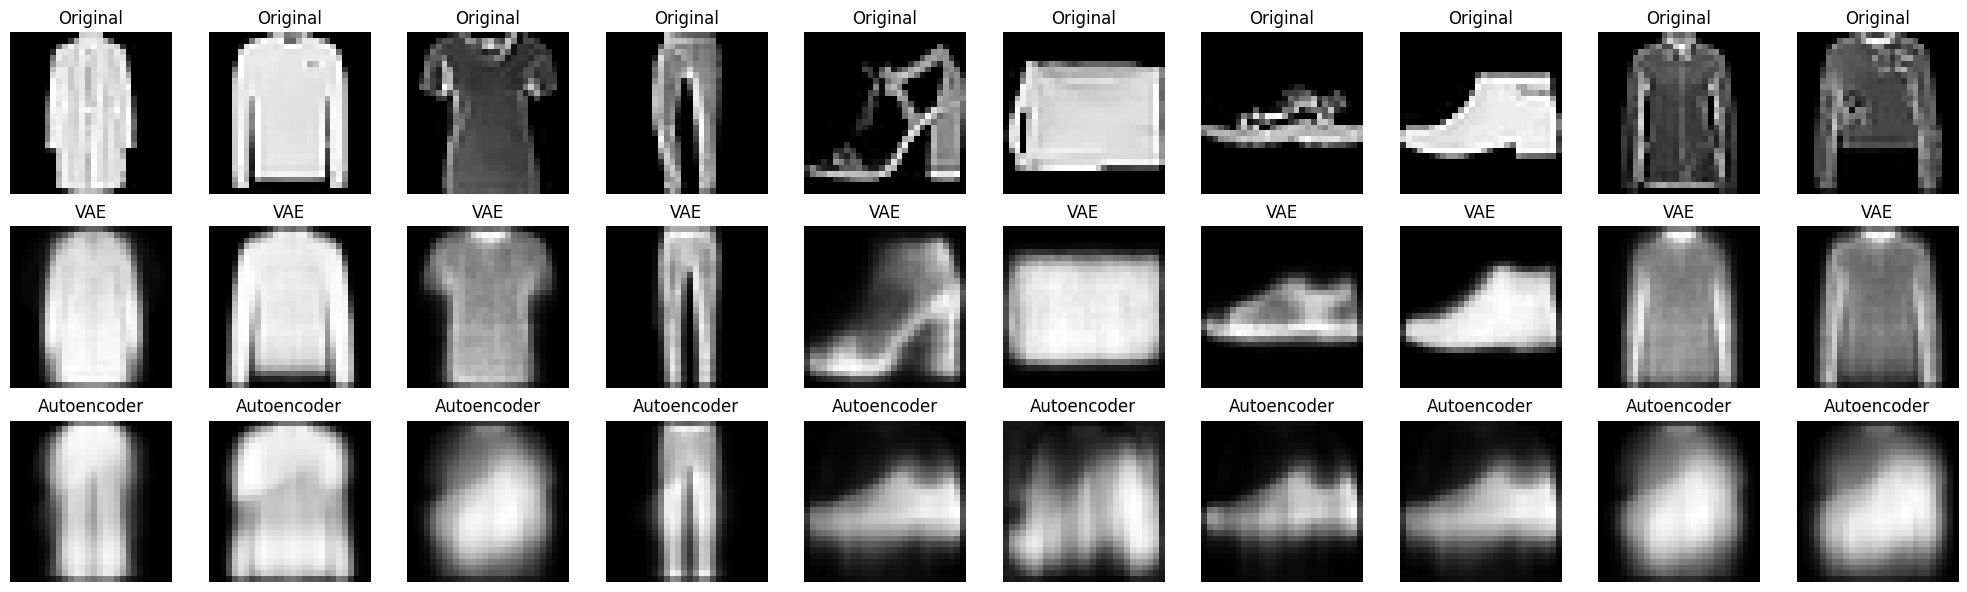

In [ ]:
def compare_reconstruction(vae_model, ae_model, x_test, n=10):
    plt.figure(figsize=(20, 6))

    # Ambil n gambar acak
    indices = np.random.randint(0, len(x_test), n)
    original_imgs = x_test[indices]

    # Prediksi/Rekonstruksi
    # VAE: encode -> ambil z_mean -> decode
    z_mean, _, _ = vae_model.encoder.predict(original_imgs)
    vae_reco = vae_model.decoder.predict(z_mean)

    # AE Biasa
    ae_reco = ae_model.predict(original_imgs)

    for i in range(n):
        # 1. Gambar Asli
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(original_imgs[i].reshape(28, 28), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # 2. VAE Reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(vae_reco[i].reshape(28, 28), cmap="gray")
        plt.title("VAE")
        plt.axis("off")

        # 3. AE Reconstruction
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_reco[i].reshape(28, 28), cmap="gray")
        plt.title("Autoencoder")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

compare_reconstruction(vae, autoencoder, x_test)